# Simple AUTOENCODER for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime
from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")
import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python36.zip', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/home/rgadea3/.ipython']


Using TensorFlow backend.


## Vamos introducir los datos de petalo preprocesados en pyhton


In [2]:
import scipy.io as sio
import hdf5storage
# datos_matlab = hdf5storage.loadmat('../datos_junio_2019/conjunto_entrenamiento_junio_2019_pitch7mm_rad165mm_29_total.mat')
npzfile = np.load('../conjuntos_datos_reconstruidos/fil5_pith7mm_rad165mm_scaled2_sig_sig_1200.npz')
npzfile.files

conjunto_datos= npzfile['arr_1']
# npzfile = np.load('../conjuntos_datos_reconstruidos/fil2_pith7mm_rad165mm_scaled2_sig_sig_1200.npz')
# npzfile.files

# conjunto_datos2= npzfile['arr_0']

# conjunto_datos=np.concatenate((conjunto_datos1,conjunto_datos2), axis=0)
# print(conjunto_datos.shape)
# conjunto_datos=conjunto_datos1
print(conjunto_datos.shape)

(50000, 3518)


## Network parameters:

In [3]:
batch_size = 500
nb_classes = 10
nb_epoch = 500

# input image dimensions
img_rows, img_cols = 20, 31
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (4, 4)

## Prepare data into training and test set.

In [4]:
# the data, shuffled and split between train and test sets
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
# conjunto_datos=photodefbox2_todo_e
numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)
maxInColumns = np.amax(conjunto_datos, axis=0)
print (maxInColumns[1])
# n, bins, patches = plt.hist(conjunto_datos[:,1], 400, normed=0, facecolor='green', alpha=0.75)


idea=conjunto_datos[:,6:3506]
veamos=idea.reshape(idea.shape[0],175, 20)
veamos2=np.zeros([idea.shape[0],20,175])
veamos2_3=np.zeros([idea.shape[0],20,525])
sector2=np.zeros([idea.shape[0],20,31])
veamos3=np.zeros([idea.shape[0],175])
# for i in range(idea.shape[0]):
for i in range(idea.shape[0]):
    veamos2[i]=np.reshape(veamos[i].transpose(), [20,175])
    veamos3[i]=np.sum(veamos2[i], axis=0)
    indice=np.argmax(veamos3[i], axis=0)
    veamos2_3[i]=np.concatenate((veamos2[i],veamos2[i],veamos2[i]),axis=1)   
    sector2[i]=veamos2_3[i,:,indice-15+175:indice+16+175]
    

print('sector shape:', sector2.shape)
conjunto_datos_nuevo=sector2.reshape(sector2.shape[0], img_rows*img_cols)
print('conjunto_datos_nuevo:', conjunto_datos_nuevo.shape)

50000
conjunto_datos shape: (50000, 3518)
194.99950513267174
sector shape: (50000, 20, 31)
conjunto_datos_nuevo: (50000, 620)


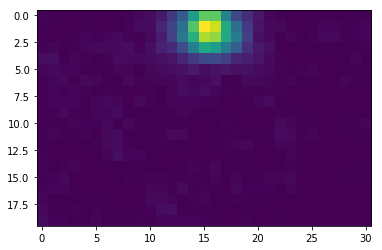

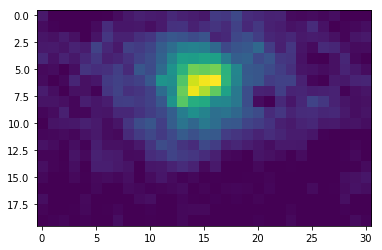

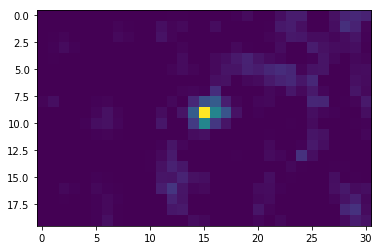

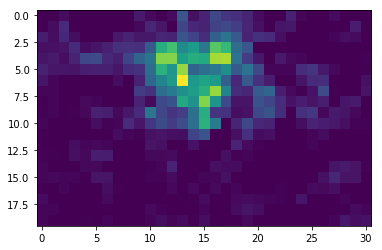

In [5]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,sector2.shape[0])
    plt.imshow(sector2[idea], cmap='viridis')
    plt.show()

In [6]:
tr_size=40
val_size=20
test_size=100-val_size-tr_size
conjunto_datos_nuevo2=np.concatenate((conjunto_datos[:,0:3],conjunto_datos_nuevo), axis=1)
tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


XY_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,:]


XY_test_bin0=XY_test[np.where((XY_test[:,1]>=164.9999) * (XY_test[:,1]<171.000))]
XY_test_bin1=XY_test[np.where((XY_test[:,1]>=171.000) * (XY_test[:,1]<177.000))]
XY_test_bin2=XY_test[np.where((XY_test[:,1]>=177.000) * (XY_test[:,1]<183.0000))]
XY_test_bin3=XY_test[np.where((XY_test[:,1]>=183.000) * (XY_test[:,1]<189.0000))]
XY_test_bin4=XY_test[np.where((XY_test[:,1]>=189.0000))]

X_train=conjunto_datos_nuevo2[:tamanyo_tr,3:]
X_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,3:]
X_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,3:]

X_test_bin0=XY_test_bin0[:,3:]
Y_test_bin0=XY_test_bin0[:,1]
print(X_test_bin0.shape)
X_test_bin1=XY_test_bin1[:,3:]
Y_test_bin1=XY_test_bin1[:,1]
print(X_test_bin1.shape)
X_test_bin2=XY_test_bin2[:,3:]
Y_test_bin2=XY_test_bin2[:,1]
print(X_test_bin2.shape)
X_test_bin3=XY_test_bin3[:,3:]
Y_test_bin3=XY_test_bin3[:,1]
print(X_test_bin3.shape)
X_test_bin4=XY_test_bin4[:,3:]
Y_test_bin4=XY_test_bin4[:,1]
print(X_test_bin4.shape)



Y_train=conjunto_datos_nuevo2[:tamanyo_tr,1] #elijo la coordenada radius
Y_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,1] #elijo la corrdenada radius
Y_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,1] #elijo la corrdenada radius

20000
10000
20000
(8655, 620)
(3929, 620)
(2550, 620)
(2132, 620)
(2734, 620)


In [7]:
img_cols=31
img_rows=20

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols,1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols,1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

X_test_bin0 = X_test_bin0.reshape(X_test_bin0.shape[0], img_rows, img_cols,1)
X_test_bin1 = X_test_bin1.reshape(X_test_bin1.shape[0], img_rows, img_cols,1)
X_test_bin2 = X_test_bin2.reshape(X_test_bin2.shape[0], img_rows, img_cols,1)
X_test_bin3 = X_test_bin3.reshape(X_test_bin3.shape[0], img_rows, img_cols,1)
X_test_bin4 = X_test_bin4.reshape(X_test_bin4.shape[0], img_rows, img_cols,1)

input_shape = (img_rows, img_cols,1)
#input_shape=input_shape.astype('int32')

In [8]:
X_train = X_train.astype('float32')
X_val= X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (20000, 20, 31, 1)
20000 train samples
10000 validation samples
20000 test samples


Display 20 random training images using image

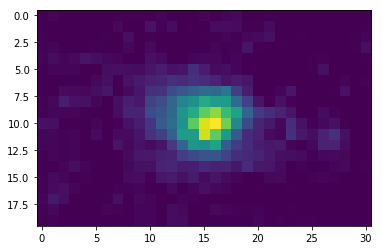

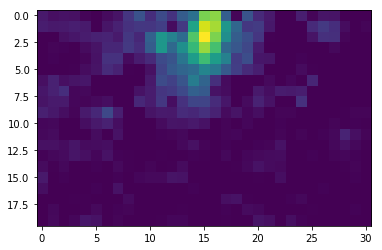

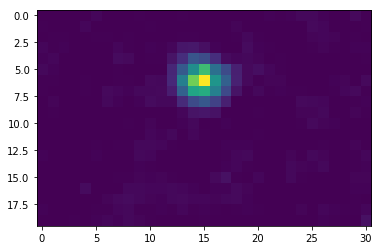

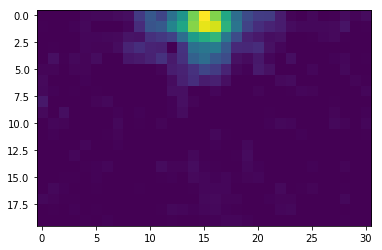

In [9]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea], [img_rows, img_cols]), cmap='viridis')
    plt.show()

## Build the CNN. 

In [10]:
model = Sequential()

model.add(Conv2D(8, kernel_size=kernel_size,
                        padding='same',
                        input_shape=(img_rows,img_cols,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(16, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(32, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1))

experimento="CNN_reconstruido"
algoritmo='adam'
tensorboard=TensorBoard(log_dir="/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/defs/{}{}{}".format(experimento,algoritmo,datetime.now()))

model.compile(loss='mean_squared_error',
              optimizer=algoritmo)



Show a summary of the model parameters. 

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 31, 8)         136       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 31, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 20, 31, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 15, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 15, 16)        2064      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 15, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 10, 15, 16)        0         
__________

And now train the model and evaluate on the test set. 

In [12]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
          verbose=1, validation_data=(X_val, Y_val),
                    callbacks=[tensorboard])

Train on 20000 samples, validate on 10000 samples
Epoch 1/500
20000/20000 [==============================] - 8s 395us/step - loss: 20026.6836 - val_loss: 14453.5636
Epoch 2/500
20000/20000 [==============================] - 1s 45us/step - loss: 6220.9785 - val_loss: 3561.7189
Epoch 3/500
20000/20000 [==============================] - 1s 55us/step - loss: 869.3489 - val_loss: 115.5722
Epoch 4/500
20000/20000 [==============================] - 1s 55us/step - loss: 53.9728 - val_loss: 22.1064
Epoch 5/500
20000/20000 [==============================] - 1s 40us/step - loss: 24.9579 - val_loss: 29.6962
Epoch 6/500
20000/20000 [==============================] - 1s 48us/step - loss: 22.2787 - val_loss: 91.8173
Epoch 7/500
20000/20000 [==============================] - 1s 53us/step - loss: 20.7595 - val_loss: 104.0394
Epoch 8/500
20000/20000 [==============================] - 1s 53us/step - loss: 19.6921 - val_loss: 125.3156
Epoch 9/500
20000/20000 [==============================] - 1s 43us/step

20000/20000 [==============================] - 1s 52us/step - loss: 12.0590 - val_loss: 2.8669
Epoch 77/500
20000/20000 [==============================] - 1s 52us/step - loss: 11.8760 - val_loss: 3.5681
Epoch 78/500
20000/20000 [==============================] - 1s 52us/step - loss: 12.1393 - val_loss: 3.0745
Epoch 79/500
20000/20000 [==============================] - 1s 52us/step - loss: 12.1589 - val_loss: 3.1492
Epoch 80/500
20000/20000 [==============================] - 1s 52us/step - loss: 12.0110 - val_loss: 4.4171
Epoch 81/500
20000/20000 [==============================] - 1s 52us/step - loss: 11.8018 - val_loss: 3.0426
Epoch 82/500
20000/20000 [==============================] - 1s 50us/step - loss: 11.8689 - val_loss: 3.0934
Epoch 83/500
20000/20000 [==============================] - 1s 52us/step - loss: 11.9450 - val_loss: 5.5886
Epoch 84/500
20000/20000 [==============================] - 1s 52us/step - loss: 11.5796 - val_loss: 2.7614
Epoch 85/500
20000/20000 [===============

20000/20000 [==============================] - 1s 52us/step - loss: 10.3544 - val_loss: 8.6360
Epoch 152/500
20000/20000 [==============================] - 1s 53us/step - loss: 10.2095 - val_loss: 7.1799
Epoch 153/500
20000/20000 [==============================] - 1s 52us/step - loss: 10.0819 - val_loss: 9.9555
Epoch 154/500
20000/20000 [==============================] - 1s 52us/step - loss: 10.0442 - val_loss: 9.2325
Epoch 155/500
20000/20000 [==============================] - 1s 53us/step - loss: 9.8941 - val_loss: 6.9626
Epoch 156/500
20000/20000 [==============================] - 1s 52us/step - loss: 10.0760 - val_loss: 4.1293
Epoch 157/500
20000/20000 [==============================] - 1s 53us/step - loss: 10.1608 - val_loss: 2.8450
Epoch 158/500
20000/20000 [==============================] - 1s 53us/step - loss: 10.1188 - val_loss: 7.5846
Epoch 159/500
20000/20000 [==============================] - 1s 51us/step - loss: 10.1407 - val_loss: 3.9524
Epoch 160/500
20000/20000 [=======

20000/20000 [==============================] - 1s 52us/step - loss: 9.2222 - val_loss: 2.4008
Epoch 227/500
20000/20000 [==============================] - 1s 52us/step - loss: 9.2848 - val_loss: 2.6817
Epoch 228/500
20000/20000 [==============================] - 1s 53us/step - loss: 9.2878 - val_loss: 2.5345
Epoch 229/500
20000/20000 [==============================] - 1s 52us/step - loss: 9.2238 - val_loss: 2.9367
Epoch 230/500
20000/20000 [==============================] - 1s 49us/step - loss: 9.0498 - val_loss: 2.8490
Epoch 231/500
20000/20000 [==============================] - 1s 52us/step - loss: 9.3776 - val_loss: 11.6665
Epoch 232/500
20000/20000 [==============================] - 1s 52us/step - loss: 9.0060 - val_loss: 4.4101
Epoch 233/500
20000/20000 [==============================] - 1s 50us/step - loss: 8.9212 - val_loss: 3.5907
Epoch 234/500
20000/20000 [==============================] - 1s 53us/step - loss: 9.0771 - val_loss: 4.8077
Epoch 235/500
20000/20000 [==============

20000/20000 [==============================] - 1s 52us/step - loss: 8.5733 - val_loss: 2.1018
Epoch 302/500
20000/20000 [==============================] - 1s 53us/step - loss: 8.3762 - val_loss: 2.2208
Epoch 303/500
20000/20000 [==============================] - 1s 52us/step - loss: 8.3920 - val_loss: 2.6682
Epoch 304/500
20000/20000 [==============================] - 1s 52us/step - loss: 8.9045 - val_loss: 3.3053
Epoch 305/500
20000/20000 [==============================] - 1s 53us/step - loss: 8.5927 - val_loss: 5.4453
Epoch 306/500
20000/20000 [==============================] - 1s 52us/step - loss: 8.2140 - val_loss: 2.6600
Epoch 307/500
20000/20000 [==============================] - 1s 53us/step - loss: 8.4367 - val_loss: 2.8615
Epoch 308/500
20000/20000 [==============================] - 1s 53us/step - loss: 8.2110 - val_loss: 3.2448
Epoch 309/500
20000/20000 [==============================] - 1s 52us/step - loss: 8.2982 - val_loss: 3.0024
Epoch 310/500
20000/20000 [===============

Epoch 377/500
20000/20000 [==============================] - 1s 45us/step - loss: 8.2062 - val_loss: 2.1645
Epoch 378/500
20000/20000 [==============================] - 1s 52us/step - loss: 8.3309 - val_loss: 3.9860
Epoch 379/500
20000/20000 [==============================] - 1s 52us/step - loss: 8.0443 - val_loss: 3.0716
Epoch 380/500
20000/20000 [==============================] - 1s 53us/step - loss: 8.4242 - val_loss: 2.3611
Epoch 381/500
20000/20000 [==============================] - 1s 52us/step - loss: 7.8941 - val_loss: 3.0188
Epoch 382/500
20000/20000 [==============================] - 1s 52us/step - loss: 8.0987 - val_loss: 3.0484
Epoch 383/500
20000/20000 [==============================] - 1s 53us/step - loss: 8.0629 - val_loss: 2.0291
Epoch 384/500
20000/20000 [==============================] - 1s 52us/step - loss: 7.8185 - val_loss: 3.1991
Epoch 385/500
20000/20000 [==============================] - 1s 51us/step - loss: 8.0414 - val_loss: 5.0631
Epoch 386/500
20000/20000 [=

Epoch 453/500
20000/20000 [==============================] - 1s 52us/step - loss: 7.5810 - val_loss: 17.2116
Epoch 454/500
20000/20000 [==============================] - 1s 51us/step - loss: 7.6742 - val_loss: 3.3399
Epoch 455/500
20000/20000 [==============================] - 1s 52us/step - loss: 7.6673 - val_loss: 2.1711
Epoch 456/500
20000/20000 [==============================] - 1s 52us/step - loss: 7.6618 - val_loss: 2.9352
Epoch 457/500
20000/20000 [==============================] - 1s 52us/step - loss: 7.6591 - val_loss: 7.3484
Epoch 458/500
20000/20000 [==============================] - 1s 52us/step - loss: 7.4462 - val_loss: 2.3276
Epoch 459/500
20000/20000 [==============================] - 1s 52us/step - loss: 7.7347 - val_loss: 2.1889
Epoch 460/500
20000/20000 [==============================] - 1s 49us/step - loss: 7.5972 - val_loss: 2.1384
Epoch 461/500
20000/20000 [==============================] - 1s 52us/step - loss: 7.8561 - val_loss: 3.6533
Epoch 462/500
20000/20000 [

In [13]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test mse:', score)
# print('Test mae:', score[1])
Y_test_predicted=model.predict(X_test)
print(Y_test_predicted[:10].flatten())
print(Y_test[:10])
error_prediction=Y_test-Y_test_predicted.flatten()

print(error_prediction[:10])

Test mse: 3.0068927169799804
[165.6564  189.45424 175.14748 181.98912 167.4427  172.85185 164.02612
 190.87547 192.54694 167.07822]
[167.54290689 191.87006942 174.66517941 181.1626643  166.95069104
 173.91936793 165.80804673 194.89500483 193.64193061 168.46273077]
[ 1.88650431  2.41583053 -0.48229679 -0.82645618 -0.49201221  1.06751551
  1.78192368  4.01953181  1.09499457  1.38451421]


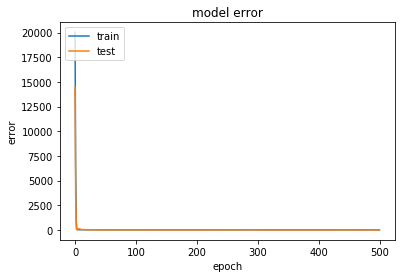

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
#print(error_prediction)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


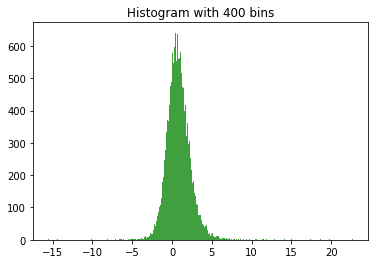

(400,)
(401,)
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 400
    # variables        = 3
    chi-square         = 58113.5174
    reduced chi-square = 146.381656
    Akaike info crit   = 1997.47561
    Bayesian info crit = 2009.45000
[[Variables]]
    amp:  594.061294 +/- 3.09186867 (0.52%) (init = 1000)
    cen:  0.62374282 +/- 0.00744536 (1.19%) (init = 0)
    wid:  1.75201826 +/- 0.01052934 (0.60%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.577



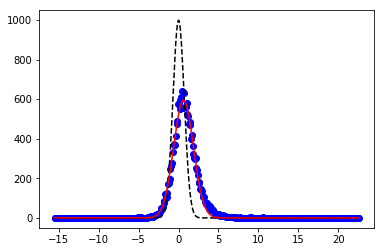

In [16]:

n, bins, patches = plt.hist(error_prediction, 400, normed=0, facecolor='green', alpha=0.75)
plt.title("Histogram with 400 bins")
plt.show()
x=bins[:400]
y=n
print(n.shape)
print(bins.shape)
from numpy import exp, loadtxt, pi, sqrt, log

from lmfit import Model
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return amp * exp(-((x-cen)/wid)**2 )


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()





In [17]:
FWHM=result.params['wid'].value*2*sqrt(log(2))

In [18]:
print(FWHM)

2.917301766252973


[[165.6564 ]
 [167.4427 ]
 [164.02612]
 ...
 [166.13177]
 [164.32756]
 [165.42271]]


/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


3.0027552331751153


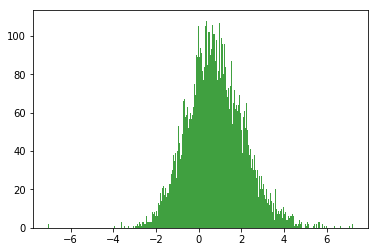

In [19]:
Y_test_bin0_predicted=model.predict(X_test_bin0)
print(Y_test_bin0_predicted)
error_prediction_bin0=Y_test_bin0-Y_test_bin0_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin0, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin0=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin0)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


2.5659707158326523


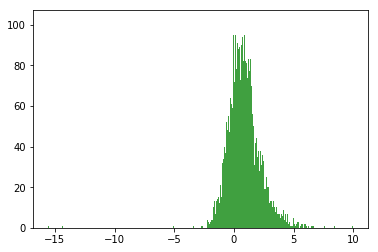

In [20]:
Y_test_bin1_predicted=model.predict(X_test_bin1)
#print(Y_test_bin1_predicted)
error_prediction_bin1=Y_test_bin1-Y_test_bin1_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin1, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin1=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin1)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


2.4549420084377576


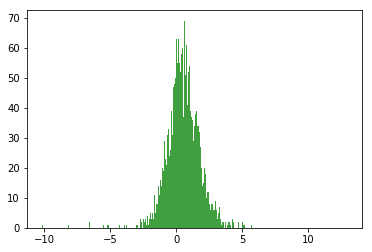

In [21]:
Y_test_bin2_predicted=model.predict(X_test_bin2)
#print(Y_test_bin2_predicted)
error_prediction_bin2=Y_test_bin2-Y_test_bin2_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin2, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin2=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin2)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


2.954275616499905


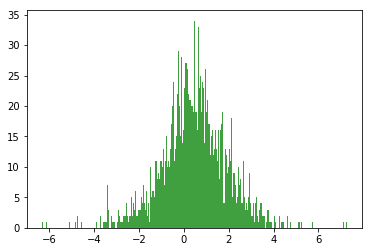

In [22]:
Y_test_bin3_predicted=model.predict(X_test_bin3)
#print(Y_test_bin3_predicted)
error_prediction_bin3=Y_test_bin3-Y_test_bin3_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin3, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin3=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin3)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


3.8881501604940953
2.954275616499905
2.4549420084377576
2.5659707158326523
3.0027552331751153


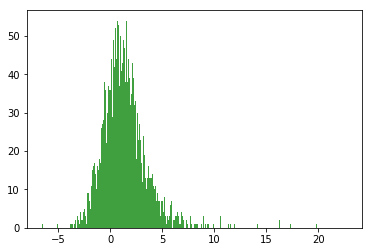

In [23]:
Y_test_bin4_predicted=model.predict(X_test_bin4)
#print(Y_test_bin4_predicted)
error_prediction_bin4=Y_test_bin4-Y_test_bin4_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin4, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin4=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin4)
print(FWHM_bin3)
print(FWHM_bin2)
print(FWHM_bin1)
print(FWHM_bin0)

In [24]:
# veamosd1 =photodefbox2_todo_fil1_e[:,-9]
# veamosd2 =[photodefbox2_todo_fil3_e(:,end-3);photodefbox2_todo_fil4_e(:,end-3)];
# veamosen1 =photodefbox2_todo_fil1_e[:,-11]
veamoser1=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,-1]
print(veamoser1.shape)
print(error_prediction.shape)
# veamosd1 =np.concatenate((photodefbox2_todo_fil1_e[:,-9],photodefbox2_todo_fil2_e[:,-9]),axis=0);
# # veerror_predictionsd2 =[photodefbox2_todo_fil3_e(:,end-3);photodefbox2_todo_fil4_e(:,end-3)];
# veamosen1 =np.concatenate((photodefbox2_todo_fil1_e[:,-11],photodefbox2_todo_fil2_e[:,-11]),axis=0);
# veamoser1=np.concatenate((photodefbox2_todo_fil1_e[:,-1],photodefbox2_todo_fil2_e[:,-1]),axis=0);

(20000,)
(20000,)


Veamos ahora los histogramnas 2d que nos interesan

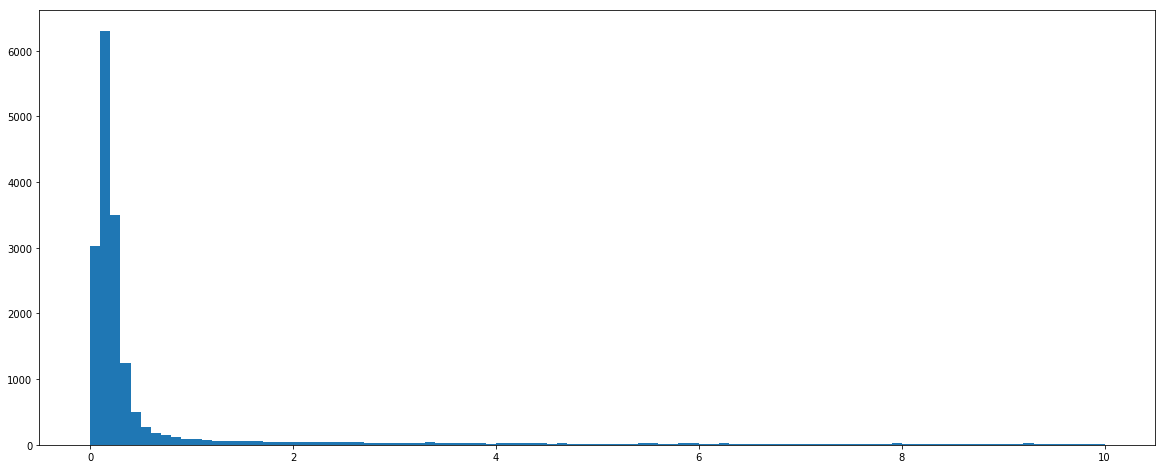

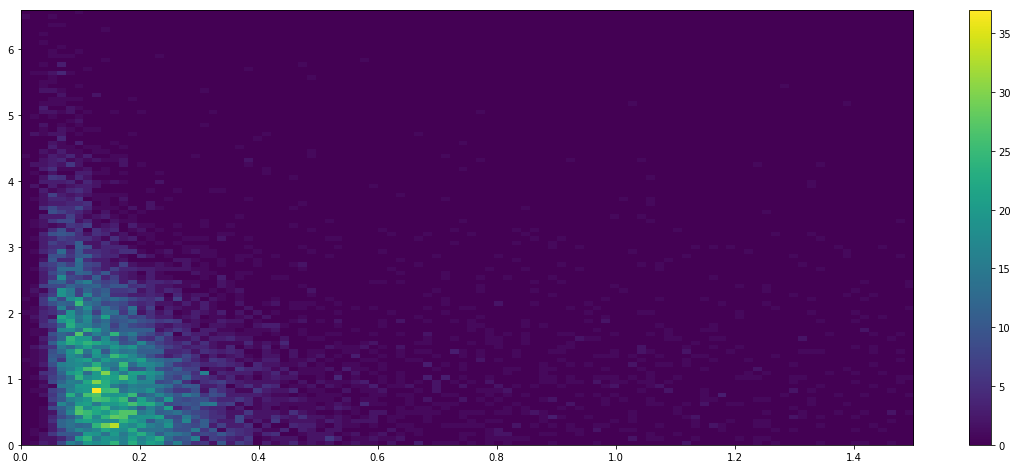

In [25]:

plt.figure(figsize=(20, 8))
plt.hist(veamoser1, bins=100, range=(0,10))

plt.figure(figsize=(20, 8))
h1=plt.hist2d(veamoser1, error_prediction, bins=100,range=[(0,1.5),(0,6.6)])
plt.colorbar(h1[3])
plt.show()

# plt.show()
# plt.figure(figsize=(20, 8))
# h2=plt.hist2d(veamoser1,veamosd1, bins=50, range=[(0,0.6),(0,0.6)])
# plt.colorbar(h2[3])
# plt.show()

# plt.figure(figsize=(20, 8))
# h3=plt.hist2d(veamoser1,veamosen1, bins=100, range=[(0,0.5),(0,0.5)])
# plt.colorbar(h3[3])
# plt.show()